In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt


import os
print(os.getcwd())
path = str(os.getcwd())
path = path.replace('\\economic_data\\notebooks', "")
path = path.replace('\\', "/")

c:\programowanie\bond\economic_data\notebooks


### MONTHLY ###

In [9]:


df = pd.read_csv(path + "/economic_data/raw_data/cpi_monthly_poland.csv", encoding='latin-1', delimiter=";")

df.rename(columns = {'Wartoæ' : 'values', 'Rok' : 'year', "Miesi¹c" : "month"}, inplace = True)
df["values"] = [float(str(i).replace(",", ".")) for i in df["values"]]
df = df[df["Sposób prezentacji"] == "Analogiczny miesi¹c poprzedniego roku = 100"]
df.drop(["Nazwa zmiennej", "Jednostka terytorialna", "Flaga",  "Sposób prezentacji", "Unnamed: 7", "Unnamed: 8"], inplace=True, axis=1)

df = df.dropna()
df["date"] =  pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-1", format='%Y-%m-%d')
df = df[df["year"] >= 2000]
df["inflation"] = round(df["values"] - 100, 2)
df.drop(["year", "month", "values"], inplace=True, axis=1)

#df.set_index('date', inplace=True)
#df.to_csv("economic_data/inflation_gus.csv")

curData = pd.DataFrame({"date" : ["2023-08-01"], "inflation" : [10.1]})


df = df.sort_values(by = "date")
df.head(10)

,date,inflation
1236,2000-01-01,10.1
1237,2000-02-01,10.4
1238,2000-03-01,10.3
1239,2000-04-01,9.8
1240,2000-05-01,10.0
1241,2000-06-01,10.2
1242,2000-07-01,11.6
1243,2000-08-01,10.7
1244,2000-09-01,10.3
1245,2000-10-01,9.9


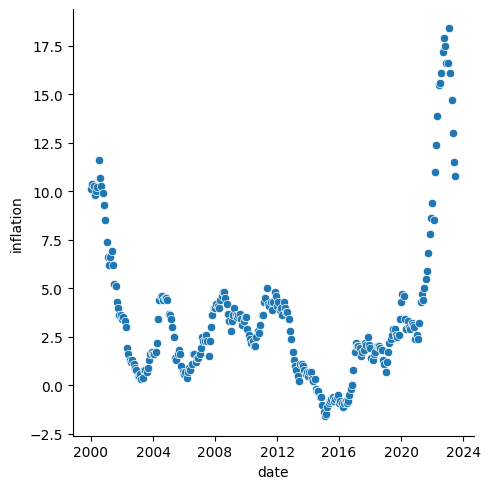

In [10]:
sns.relplot(data=df, x = "date", y = "inflation")
plt.show()

In [11]:
df.set_index('date', inplace=True)

smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

c:\Users\proso\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=423.009, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1736.155, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1370.199, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=407.918, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=407.206, Time=0.48 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=405.886, Time=0.62 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=407.040, Time=0.23 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=404.141, Time=0.85 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=414.618, Time=0.68 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=412.004, Time=0.92 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 4.775 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  283
Model:               SARIMAX(3, 0, 3)   Log Likelihood                -195.071
Date:                Wed, 20 Sep 2023   AIC                            404.141
Time:                        18:18:06   BIC                            429.659
Sample:                    01-01-2000   HQIC                           414.373
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.9139      0.060     48.250      0.000       2.796       3.032
ar.L2         -2.8614      0.117    -24.484      0.000      -3.090      -2.632
ar.L3          0.9469      0.057     16.590      0.000       0.835       1.059
ma.L1         -1.6448      0.077    -21.404      0.000      -1.795      -1.494
ma.L2          0.5300      0.096      5.544      0.000       0.343       0.717
ma.L3          0.1813      0.057      3.157      0.002       0.069       0.294
sigma2         0.2271      0.014     16.673      0.000       0.200       0.254
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               346.20
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

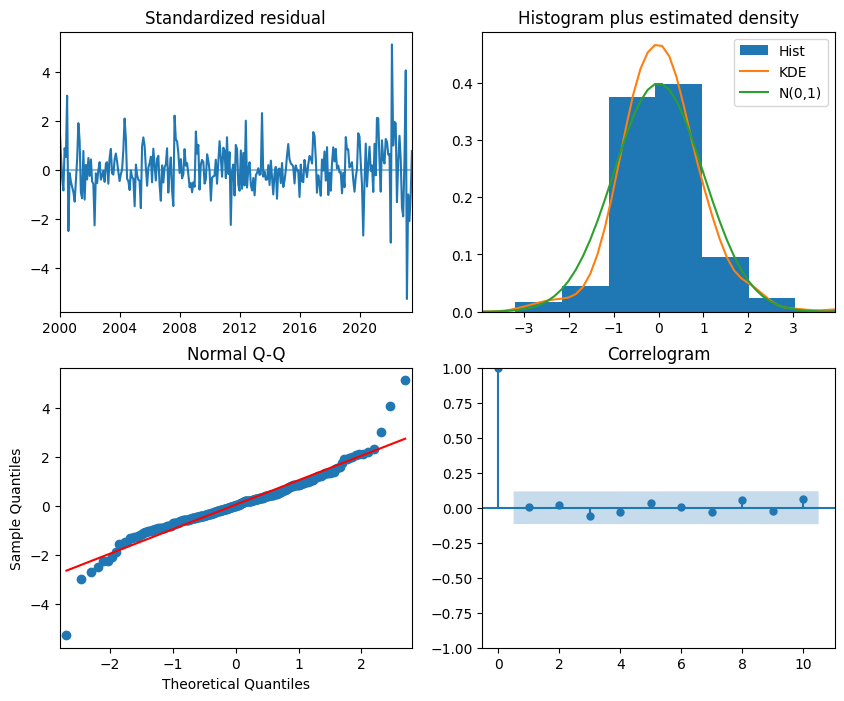

In [12]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

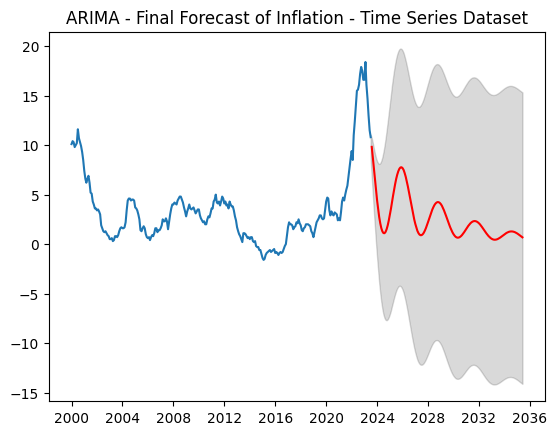

In [13]:
n_periods = 144

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, alpha = .01)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of Inflation - Time Series Dataset")
plt.show()

In [14]:
print(upper_series[-1])
print(fitted[-1])
print(lower_series[-1])

15.328048118024439
0.6048778680279676
-14.118292381968503


In [15]:
inflation_df = pd.DataFrame({'date':fitted.index, 'inflation':fitted.values, "upper" : upper_series, "lower" : lower_series})
inflation_df

,date,inflation,upper,lower
2023-07-01,2023-08-01,9.823953,11.051593,8.596313
2023-08-01,2023-09-01,8.720105,10.703691,6.736518
2023-09-01,2023-10-01,7.593738,10.191840,4.995635
2023-10-01,2023-11-01,6.478712,9.648742,3.308683
2023-11-01,2023-12-01,5.407302,9.137843,1.676761
...,...,...,...,...
2035-02-01,2035-03-01,0.927727,15.644799,-13.789345
2035-03-01,2035-04-01,0.846426,15.564855,-13.872003
2035-04-01,2035-05-01,0.763975,15.483859,-13.955909
2035-05-01,2035-06-01,0.682718,15.404176,-14.038741


In [18]:
inflation_df = pd.DataFrame({'date':fitted.index, 'inflation':np.round(fitted.values, 2), 
                             "upper" : np.round(upper_series, 2), "lower" : np.round(lower_series, 2)})


inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["month"] = inflation_df["date"].dt.month
inflation_df["year"] = inflation_df["date"].dt.year

inflation_df = inflation_df.reset_index()
inflation_df = inflation_df.drop(["index","date"], axis=1)


inflation_df.to_csv(path + "/economic_data/predicted_inflation.csv", index=False)